[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/tree/main/tarea3-atencion/1_edades.ipynb)

# Predicción de edades
Daniel Alejandro Alonso Bastos

Usa el conjunto de datos UTKFaces para entrenar y evalúar un modelo basado en la arquitectura [ViT](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/4a_vit_dogs.ipynb.) que prediga la edad de una persona dada la foto de su rostro, tratando la tarea como un problema de regresión. Agrega un bloque ResNet después de la capa convolucional que procesa los parches en ViT, entrena un modelo con la arquitectura modificada y compara su desempeño con ViT. Discute los resultados que obtuviste con las diferentes configuraciones.

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# inspeccionar arquitecturas
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os # sistema de archivos
import matplotlib.pyplot as plt
import random

from PIL import Image # imágenes

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as tvm
from torchvision import transforms as T
from torchvision.ops import Permute

# inspeccion de la arquitectura
from torchsummary import summary

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

## 1.2 Auxiliares

In [9]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
COLS = 8
ROWS = BATCH_SIZE // COLS
#ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64
# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  #plt.ylim([0,100])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model loss')
  plt.grid()
  plt.show()

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Descarga de UTKFace

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2022-12-10 02:49:47--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/faces/UTKFace.tar.gz’

../data/faces/UTKFa 100%[===================>] 101.69M   382KB/s    in 5m 5s   

2022-12-10 02:54:55 (341 KB/s) - ‘../data/faces/UTKFace.tar.gz’ saved [106634631/106634631]



Las etiquetas de cada imagen se encuentran dentro del nombre de la imagen, con el siguiente formato:
```
[age]_[gender]_[race]_[date&time].jpg
```
Donde:
* `[age]` es la edad y se representa por un entero $\in[0,116]$
* `[gender]` indica el género donde 0 es para masculino y 1 para femenino.
* `[race]` indica la raza y es un entero del 0 al 4, siendo blanco, negro, asiático, indio y otros.
* `[date&time]` es la fecha y hora que la imagen fue recolectada, siguiendo el formato yyyymmddHHMMSSFFF

In [5]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


### 2.2 Tubería de datos

Para realizar la división aleatoria de los subconjuntos de prueba y entrenamiento, se obtiene la lista de imágenes descargadas, y después se realiza un muestreo aleatorio sin remplazo de dicha lista del tamaño del subconjunto de entrenamiento, el subconjunto restante sería el de prueba.

In [6]:
imgs = os.listdir(data_dir) # lista con el nombre de todas las imagenes
trn_size = int(TRN_SIZE * len(imgs)) # tamaño del conjunto de entrenamiento
tst_size = len(imgs) - trn_size # tamaño del conjunto de prueba
# lista con los nombres de las imagenes del conjunto de entrenamiento
trn_names = np.random.choice(imgs,trn_size,replace=False)
# lista con los nombres de las imagenes del conjunto de prueba
tst_names = list(set(imgs)-set(trn_names))

print(f'Número de imagenes: {len(imgs)}')
print(f'Tamaño del conjunto de entrenamiento: {len(trn_names)}')
print(f'Tamaño del conjunto de prueba: {len(tst_names)}')

Número de imagenes: 23708
Tamaño del conjunto de entrenamiento: 18966
Tamaño del conjunto de prueba: 4742


Se implementa una tubería de datos para configurar, leer, transformar y etiquetar las imágenes según su nombre, además de regresar el subconjunto de entrenamiento y prueba según sea especificado.

In [7]:
class UTKFaceDS:
  
  # configuracion, lectura y transformacion de los datos
  def __init__(self, root, subset, transform=None):
    # guardar la transformacion para las imagenes
    self.transform = transform

    # lista con las rutas a las imagenes
    self.paths = []
    # lista con las etiquetas de las imagenes
    self.labels = []

    # obtener la lista de nombres segun el subconjunto
    names = trn_names if subset == 'train' else tst_names

    # asignar a cada imagen su etiqueta -> edad
    for name in names:
      #age, gender, race, _ = name.split('_')
      age = name.split('_')[0] # [age] es la edad dentro del nombre de la imagen
      self.labels.append(age) # agregar edad
      self.paths.append(f'{data_dir}/{name}') # agregar ruta

  # regresar un elemento
  def __getitem__(self, i):
    # obtener la ruta de la imagen
    path = self.paths[i]
    # carga de la imagen
    x = Image.open(path)
    # aplicar la transformacion
    if self.transform is not None:
      x = self.transform(x)
    # leer etiqueta -> edad
    y = np.array(self.labels[i], np.float32).reshape(1)
    # regresar el ejemplo
    return x,y
  
  # numero de elementos en el conjunto
  def __len__(self):
    return len(self.paths)

### 2.3 Transformaciones y cargadores de datos

#### 2.3.1 Conjunto de entrenamiento

En el conjunto de entrenamiento se realiza un acrecentamiento de datos al utilizar un espejeo horizontal. Se redimensionan las imágenes de 200x200 a 64x64 para disminuir el tiempo de entrenamiento.

Tamaño del conjunto de entrenamiento: 18966
x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


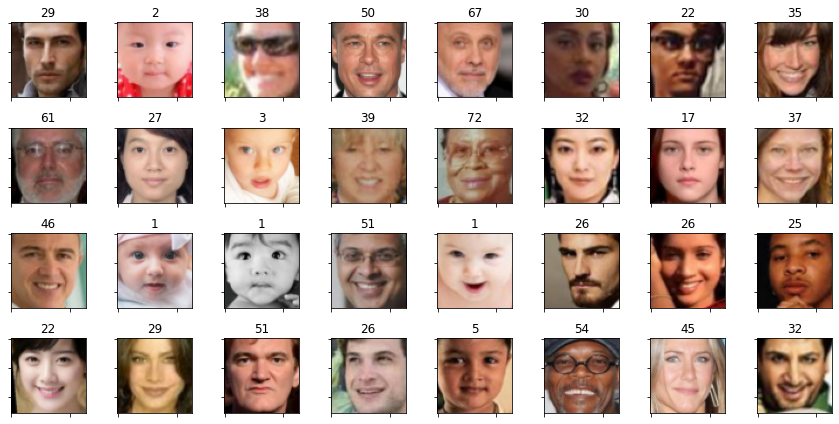

In [10]:
# transformacion de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamiento de las imagenes
    T.Resize((IMG_SIZE, IMG_SIZE)),
    # aumentado de datos
    # espejeo horizontal
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de entrenamiento
trn_ds = UTKFaceDS(data_dir, 'train', transform=trn_tsfm)
print(f'Tamaño del conjunto de entrenamiento: {len(trn_ds)}')

# entrenamiento
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS, pin_memory=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

#### 2.3.2 Conjunto de prueba

Tamaño del conjunto de prueba: 4742
x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


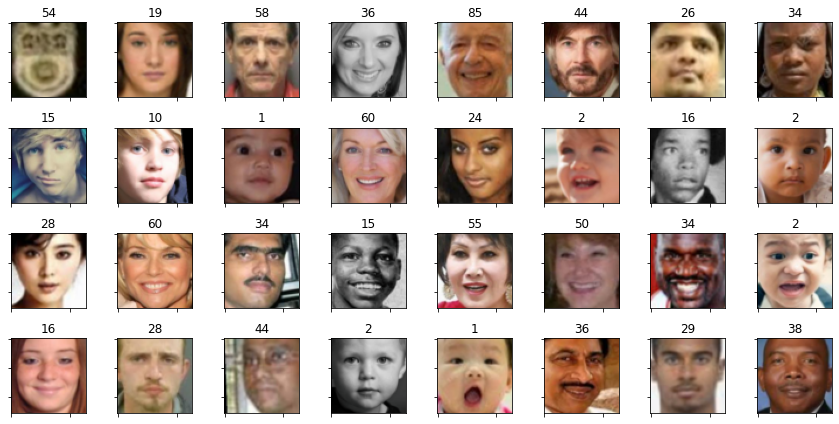

In [11]:
# transformacion de prueba
tst_tsfm = T.Compose([
    # redimensionamiento de las imagenes
    T.Resize((IMG_SIZE, IMG_SIZE)),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de prueba
tst_ds = UTKFaceDS(data_dir, 'test', transform=tst_tsfm)
print(f'Tamaño del conjunto de prueba: {len(tst_ds)}')

# entrenamiento
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS, pin_memory=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3 Modelos

### 3.1 Arquitectura ViT

La arquitectura que ViT implementada está basada en el notebook [4a_vit_dogs.ipynb](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/4a_vit_dogs.ipynb), realizando una modificación para utilizarla en un problema de regresión.

- Definir auto atención producto punto

\begin{equation}
\mbox{MultiHead}(Q, K, V) = \text{Concat}(\mbox{head}_1,\mbox{head}_2,\ldots,\mbox{head}_h)W^O,
\end{equation}

\begin{equation}
\mbox{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) = \text{softmax}\left[\frac{QW_i^Q(KW_i^K)^T}{\sqrt{d_k}}\right]VW_i^V,
\end{equation}

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.qw = nn.Linear(dim, dim, bias = bias)
        self.kw = nn.Linear(dim, dim, bias = bias)
        self.vw = nn.Linear(dim, dim, bias = bias)

        self.ow = nn.Linear(dim, dim, bias = bias)

    def forward(self, x):
        q = self.qw(x)
        k = self.qw(x)
        v = self.qw(x)

        B, L, D = q.shape
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])
        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        attn = F.softmax(qk, dim=-1)
        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, L, D])

        x = self.ow(v_attn)
        return x

test_layer = Attention(32, 2)
test_layer(torch.ones([1, 256, 32])).shape

torch.Size([1, 256, 32])

- Definir ViT:

\begin{align}
    \mathbb{h}_0 &= [ \mathbb{x}_\text{class}, \, \mathbb{x}_1 E, \ldots, \, \mathbb{x}_N E ] + E_{pos},
    &&  E_{pos}  \in \mathbb{R}^{(N + 1) \times D} \\
    \mathbb{h}^\prime_\ell &= \text{MSA}(\text{LN}(\mathbb{h}_{\ell-1})) + \mathbb{h}_{\ell-1}, && \ell=1,\ldots,L \\
    \mathbb{h}_\ell &= \text{MLP}(\text{LN}(\mathbb{h}^\prime_{\ell})) + \mathbb{h}^\prime_{\ell}, && \ell=1,\ldots,L   \\
    \mathbb{y} &= \text{LN}(\mathbb{h}_L^0)
\end{align}

In [13]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads)
        self.ln_2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        x = self.attn(self.ln_1(x)) + x
        return self.mlp(self.ln_2(x)) + x

test_layer = Transformer(64, 2, 256)
test_layer(torch.ones([1, 64, 64])).shape

torch.Size([1, 64, 64])

In [14]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, dim, 
                 depth, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.dim = dim
        self.n_patches = (img_size // patch_size)**2
        
        self.patches = nn.Conv2d(3, dim, patch_size, 
                                 stride=patch_size, padding=0)

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.Sequential()
        for _ in range(depth):
            self.transformer.append(Transformer(dim, heads, mlp_dim))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
            #nn.Sigmoid(),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patches(x)

        x = torch.permute(x, [0, 2, 3, 1])
        x = torch.reshape(x, [B, self.n_patches, self.dim])

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)

Crear una instancia y comprobar que esté funcionando.

In [15]:
patch_size = 16
out_dim = 1
model_dim = 64
depth = 3
heads = 4
mlp_dim = 64
dropout = 0.5

vit = ViT(IMG_SIZE, patch_size, out_dim, 
          model_dim, depth, heads, mlp_dim, dropout)

summary(vit, (3, IMG_SIZE, IMG_SIZE), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]          49,216
         LayerNorm-2               [-1, 17, 64]             128
            Linear-3               [-1, 17, 64]           4,160
            Linear-4               [-1, 17, 64]           4,160
            Linear-5               [-1, 17, 64]           4,160
            Linear-6               [-1, 17, 64]           4,160
         Attention-7               [-1, 17, 64]               0
         LayerNorm-8               [-1, 17, 64]             128
            Linear-9               [-1, 17, 64]           4,160
             GELU-10               [-1, 17, 64]               0
          Dropout-11               [-1, 17, 64]               0
           Linear-12               [-1, 17, 64]           4,160
          Dropout-13               [-1, 17, 64]               0
      Transformer-14               [-1,

In [16]:
# inferencia con datos sinteticos
x = torch.zeros(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
y = vit(x)
print(f'{x.shape} => {y.shape}')

torch.Size([32, 3, 64, 64]) => torch.Size([32, 1])


### 3.2 Arquitectura ViT con un bloque ResNet

A continuación se realiza la arquitectura ViT para un problema de regresión pero añadiendo un bloque ResNet después de la capa convolucional que procesa los parches ViT `patches`

#### 3.2.1 Definición de bloque ResNet

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/b0727676e55073692332894e0bec830235888fa6/figs/resnetblock.svg" width="350"/>

In [17]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # [N, O1, H, W]
            nn.ReLU(),
            
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # [N, O2, H, W]
            nn.ReLU(),
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x

El bloque ResNet definido se coloca después de la capa convolucional que procesa los parches en ViT, que toma como entrada y salida de canales las dimensiones del modelo `dim`, que es el parámetro `model_dim`, definido anteriormente

In [18]:
class ViT_ResNet(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, dim, 
                 depth, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.dim = dim
        self.n_patches = (img_size // patch_size)**2
        
        self.patches = nn.Conv2d(3, dim, patch_size, 
                                 stride=patch_size, padding=0)
        # agregar bloque ResNet
        self.resnet = ResBlock(in_channels=dim, out_channels=(dim,dim))

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.Sequential()
        for _ in range(depth):
            self.transformer.append(Transformer(dim, heads, mlp_dim))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
            #nn.Sigmoid(),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patches(x)
        # agregar bloque ResNet
        x = self.resnet(x)

        x = torch.permute(x, [0, 2, 3, 1])
        x = torch.reshape(x, [B, self.n_patches, self.dim])

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)

In [19]:
vit_resnet = ViT_ResNet(IMG_SIZE, patch_size, out_dim, 
          model_dim, depth, heads, mlp_dim, dropout)

summary(vit_resnet, (3, IMG_SIZE, IMG_SIZE), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]          49,216
            Conv2d-2             [-1, 64, 4, 4]          36,928
       BatchNorm2d-3             [-1, 64, 4, 4]             128
              ReLU-4             [-1, 64, 4, 4]               0
            Conv2d-5             [-1, 64, 4, 4]          36,928
       BatchNorm2d-6             [-1, 64, 4, 4]             128
              ReLU-7             [-1, 64, 4, 4]               0
          ResBlock-8             [-1, 64, 4, 4]               0
         LayerNorm-9               [-1, 17, 64]             128
           Linear-10               [-1, 17, 64]           4,160
           Linear-11               [-1, 17, 64]           4,160
           Linear-12               [-1, 17, 64]           4,160
           Linear-13               [-1, 17, 64]           4,160
        Attention-14               [-1,

In [20]:
# inferencia con datos sinteticos
x = torch.zeros(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
y = vit_resnet(x)
print(f'{x.shape} => {y.shape}')

torch.Size([32, 3, 64, 64]) => torch.Size([32, 1])


## 4 Ciclo de entrenamiento

In [21]:
! nvidia-smi

Sat Dec 10 02:58:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |    572MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
def train_epoch(data_loader,model,opt,epoch):
  # loop sobre cada lote en el conjunto de entrenamiento
  for x, y_true in data_loader:
  #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Train'):
    # mover a dispositivo
    x = x.to(device)
    y_true = y_true.to(device)
    # se realiza inferencia
    y_hat = model(x)
    # se calcula la perdida
    loss = F.mse_loss(y_hat, y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model, epoch):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses = []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in data_loader:
    #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Test'):
      # mover a dispositivo
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) # calculamos y_hat
      loss_b = F.mse_loss(y_hat, y_true) # calculo de la perdida
      losses.append(loss_b.item()) # guardar historial de perdida para el lote
    
    # se obtiene el promedio
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          L2lambda=0,progress=True):
  
  # mover modelo a cpu/gpu
  model = model.to(device)

  # historiales
  loss_hist = []

  # optimizadores
  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  # colocar el modelo en modo de evaluacion
  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # colocar al modelo en modo de entrenamiento
    model.train()
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer,epoch)
    # modelo en modo evaluacion
    model.eval()
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss = eval_epoch(train_dl, model, epoch)
    test_loss = eval_epoch(test_dl, model, epoch)
    # actualizar historial
    loss_hist.append([train_loss,test_loss])

    # impresion del progreso
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]')
      
  return loss_hist

La siguiente función tiene como objetivo realizar una evaluación del modelo entrenado y mostrar las imágenes con el valor real $y$ y el valor predicho $\hat{y}$.

Se usa para validar los resultados de los distintos ejercicios de entrenamiento.

In [24]:
# funcion para realizar una evaluacion junto con sus resultados
def evaluation(dl,model):
  model.to(device).eval()
  with torch.no_grad():
    x, y_true = next(iter(dl))
    y_pred = model(x.to(device))
    titles = []
    for i in range(len(y_true)):
      titles.append(f'y={int(y_true[i].item())},y_h={int(y_pred[i].item())}')
    display_batch(x, titles, ROWS, COLS)

### 4.1 Entrenamiento del modelo con la arquitectura ViT

En esta sección se realizó el entrenamiento utilizando la arquitectura ViT como un problema de regresión.

El entrenamiento se comporta de buena manera dado que la pérdida va disminuyendo y no se muestra algún comportamiento de overfitting, al menos durante las primeras 15 épocas, después de la 15 se comineza a observar una separación más grande de la pérdida del conjunto de entrenamiento y de prueba.

Nota: La línea azul representa la función de pérdida del conjunto de entrenamiento y la línea naranja representa la función de pérdida del conjunto de prueba.

In [25]:
loss_vit = train(vit, trn_dl, tst_dl,epochs=25,lr=1e-3,opt='Adam',progress=True)

  0%|          | 0/25 [00:00<?, ?it/s]

E00 loss=[358.62,358.04]
E01 loss=[258.24,263.05]
E02 loss=[212.87,220.44]
E03 loss=[185.93,196.82]
E04 loss=[167.51,181.51]
E05 loss=[166.37,187.66]
E06 loss=[165.01,181.35]
E07 loss=[141.93,164.26]
E08 loss=[147.48,161.82]
E09 loss=[136.33,152.73]
E10 loss=[151.83,176.00]
E11 loss=[126.40,150.21]
E12 loss=[133.29,154.76]
E13 loss=[121.31,143.37]
E14 loss=[120.16,138.81]
E15 loss=[139.34,167.18]
E16 loss=[129.68,148.99]
E17 loss=[116.53,143.55]
E18 loss=[111.30,135.14]
E19 loss=[108.60,134.23]
E20 loss=[108.97,135.47]
E21 loss=[107.99,133.52]
E22 loss=[106.23,132.92]
E23 loss=[108.85,137.88]
E24 loss=[106.12,140.10]


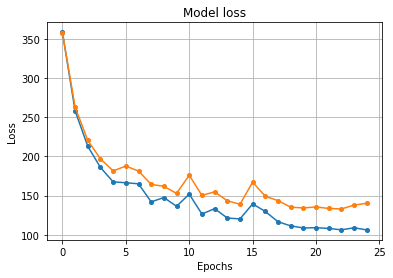

In [26]:
display_losses(loss_vit)

Predicciones del modelo

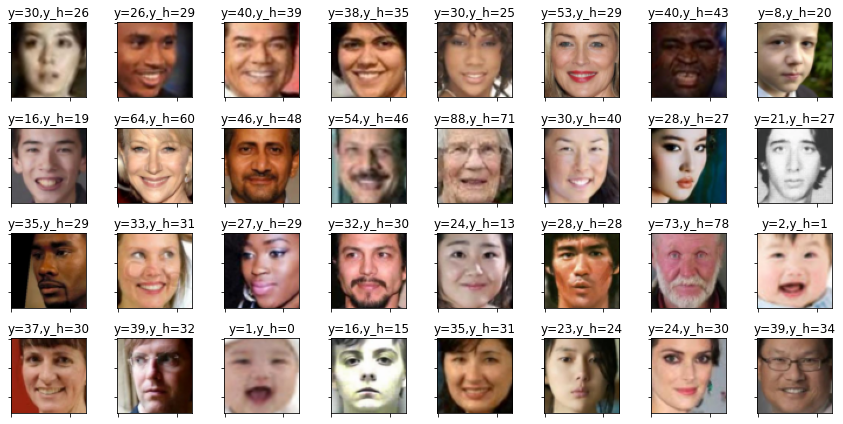

In [27]:
evaluation(tst_dl, vit)

### 4.2 Entrenamiento del modelo con la arquitectura ViT con ResNet

En esta sección se realizó el entrenamiento de la arquitectura ViT con un bloque ResNet después de la capa de convolución que procesa los parches ViT, de lo cual se observa que:
* Aumenta en aproximadamente 70,000 el número de parámetros respecto a la arquitectura ViT, pero el tiempo de entrenamiento es similar
* La función de pérdida tanto del conjunto de entrenamiento como el de prueba van disminuyendo, lo cual está bien, pero se comeinzan a separar a partir de la época 5, lo que puede ser un síntoma de overfitting, dado que puede estar sobreparametrizado
* Respecto a la arquitectura ViT, se puede observar que en la época 15, que es antes de que se separen, tienen pérdidas en el conjunto de prueba cercanas a 140, mientras que en la arquitectura ViT con ResNet se muestra el mismo comportamiento pero en la época 5, por lo que, al menos en este ejercicio se observa que el bloque ResNet le ayuda a aprender más rápido, pero también cae en síntomas de overfitting más rápido
* Persiste un problema, para las personas cercanas a los 28 años, el modelo a veces asierta pero también los confunde con personas de cercanas a los 50 años o en el otro extremo, a personas cercanas a los 15 años

Nota: La línea azul representa la función de pérdida del conjunto de entrenamiento y la línea naranja representa la función de pérdida del conjunto de prueba.



In [28]:
loss_vit_r = train(vit_resnet, trn_dl, tst_dl,epochs=25,lr=1e-3,
                   opt='Adam',progress=True)

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


E00 loss=[301.24,301.30]
E01 loss=[192.12,205.26]
E02 loss=[145.96,160.63]
E03 loss=[133.87,150.39]
E04 loss=[127.74,147.34]
E05 loss=[117.68,142.31]
E06 loss=[108.40,134.63]
E07 loss=[106.16,130.43]
E08 loss=[101.19,126.45]
E09 loss=[ 94.72,126.05]
E10 loss=[ 90.91,120.78]
E11 loss=[ 90.53,123.48]
E12 loss=[ 89.12,125.44]
E13 loss=[ 90.65,124.05]
E14 loss=[ 85.44,124.00]
E15 loss=[ 74.32,111.55]
E16 loss=[ 76.64,111.77]
E17 loss=[ 80.20,113.45]
E18 loss=[ 72.99,109.58]
E19 loss=[ 69.69,108.91]
E20 loss=[ 76.17,113.17]
E21 loss=[ 77.39,116.51]
E22 loss=[ 70.27,110.28]
E23 loss=[ 62.74,103.81]
E24 loss=[ 70.21,115.13]


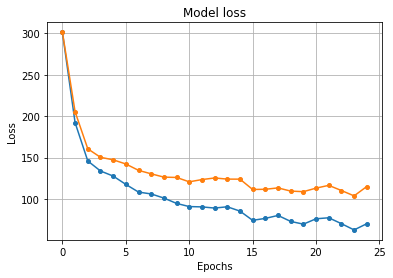

In [29]:
display_losses(loss_vit_r)

Predicciones del modelo

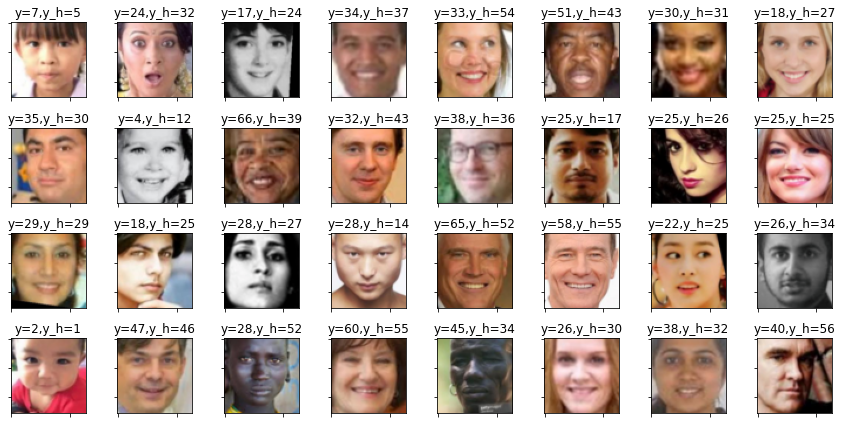

In [30]:
evaluation(tst_dl, vit_resnet)